In [15]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

/tmp/ipykernel_9663/3023366913.py:1: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [16]:
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib.cm import ScalarMappable
from matplotlib import patches as mpatches
import numpy as np
import os
import time
from scipy import stats
import gc
import warnings
import math
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve

In [17]:
def calc_ci(array, confidence=0.95):
    a = 1.0 * np.array(array)
    n = len(a)
    m, se = np.mean(a), stats.sem(a)
    h = se * stats.t.ppf((1+confidence) / 2, n-1)
    return m-h, m, m+h

In [18]:
data = pd.read_csv('/home/rjsietsma/PycharmProjects/capice_updatr/datafiles/Thresholds/Clinvar20211002_VKGLsept2021_merged_notrain_withlabels.csv.gz')
data['sample'] = data.index
data

/home/rjsietsma/PycharmProjects/capice_updatr/venv/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3251: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,GeneName,FeatureID,Consequence,probabilities,class,binarized_label,chr,pos,ref,alt,review,sample
0,AGRN,ENST00000379370,SYNONYMOUS,0.000008,LB,0.0,1,984655,C,T,NaN,0
1,AGRN,ENST00000379370,SYNONYMOUS,0.001777,VUS,NaN,1,985377,C,T,NaN,1
2,RNF223,ENST00000453464,NON_SYNONYMOUS,0.001283,LB,0.0,1,1007730,C,T,NaN,2
3,TNFRSF4,ENST00000379236,NON_SYNONYMOUS,0.000100,LB,0.0,1,1149479,C,A,NaN,3
4,ATAD3B,ENST00000308647,NON_SYNONYMOUS,0.065817,VUS,NaN,1,1407281,G,A,NaN,4
...,...,...,...,...,...,...,...,...,...,...,...,...
817432,CACNA1B,ENST00000371372,SPLICE_SITE,0.000165,VUS,NaN,9,141014823,C,T,NaN,817432
817433,CACNA1B,ENST00000371372,INTRONIC,0.000282,B,0.0,9,141015603,T,C,NaN,817433
817434,CACNA1B,ENST00000371372,NON_SYNONYMOUS,0.021771,VUS,NaN,9,141015982,G,A,NaN,817434
817435,CACNA1B,ENST00000371372,SYNONYMOUS,0.000839,LB,0.0,9,141015983,C,T,NaN,817435


In [19]:
gron = pd.read_csv('/home/rjsietsma/PycharmProjects/capice_updatr/datafiles/Thresholds/VKGL_sept2021_Groningen_withlabels_capice.csv.gz')
gron['sample'] = gron.index
gron

,GeneName,FeatureID,Consequence,probabilities,chr,pos,ref,alt,class,review,binarized_label,sample
0,ISG15,ENST00000379389,STOP_GAINED,0.047104,1,949682,A,T,P,NaN,1.0,0
1,AGRN,ENST00000379370,SPLICE_SITE,0.000006,1,977330,T,C,B,NaN,0.0,1
2,AGRN,ENST00000379370,SYNONYMOUS,0.000001,1,981931,A,G,B,NaN,0.0,2
3,AGRN,ENST00000379370,INTRONIC,0.000005,1,982941,T,C,B,NaN,0.0,3
4,AGRN,ENST00000379370,SYNONYMOUS,0.000153,1,982994,T,C,B,NaN,0.0,4
...,...,...,...,...,...,...,...,...,...,...,...,...
20218,RAB39B,ENST00000369454,SYNONYMOUS,0.000022,X,154490187,T,C,LB,NaN,0.0,20218
20219,CLIC2,ENST00000369449,NON_SYNONYMOUS,0.001572,X,154563706,C,T,VUS,NaN,NaN,20219
20220,TMLHE,ENST00000334398,NON_SYNONYMOUS,0.000948,X,154736715,T,C,VUS,NaN,NaN,20220
20221,TMLHE,ENST00000334398,NON_SYNONYMOUS,0.002784,X,154743837,T,A,LB,NaN,0.0,20221


In [20]:
thresholds_loc = '/home/rjsietsma/PycharmProjects/capice_updatr/datafiles/Thresholds/gene_tracking_v2.csv.gz'
thresholds = pd.DataFrame(
    columns=[
        'pathogenic_threshold',
        'n_pathogenic_total',
        'n_pathogenic_correct',
        'benign_threshold',
        'n_benign_total',
        'n_benign_correct',
        'final_confidence',
        'gene_name',
        'vkgl_b_corr',
        'vkgl_b_vus',
        'vkgl_b_wro',
        'vkgl_p_corr',
        'vkgl_p_vus',
        'vkgl_p_wro',
        'vkgl_vus_b',
        'vkgl_vus_vus',
        'vkgl_vus_p',
        'high_confidence'
    ]
)
if not os.path.isfile(thresholds_loc):
    thresholds.to_csv(thresholds_loc, index=False, compression='gzip')
    print(f'Created {thresholds_loc}')
thresholds

,pathogenic_threshold,n_pathogenic_total,n_pathogenic_correct,benign_threshold,n_benign_total,n_benign_correct,final_confidence,gene_name,vkgl_b_corr,vkgl_b_vus,vkgl_b_wro,vkgl_p_corr,vkgl_p_vus,vkgl_p_wro,vkgl_vus_b,vkgl_vus_vus,vkgl_vus_p,high_confidence


In [21]:
#TODO: add 5GPM gene panel genes to see how well this panel does (PPV >= 0.8 & NPV >= 0.8)

genes_of_interest = ['BRCA1', 'COL7A1', 'TTN', 'MEFV', 'APOB', 'JPH2', 'CDSN', 'HCFC1', 'TERC', 'POLE', 'ROBO4']
# genes_of_interest = ['BRCA1', 'COL7A1', 'TTN', 'MEFV', 'APOB', 'JPH2', 'CDSN']
# weird_genes = ['APOB', 'JPH2', 'CDSN', 'HCFC1']
merge = data
# merge = data[data['GeneName'].isin(genes_of_interest)]
# merge.reset_index(drop=True, inplace=True)
# merge._is_copy = None
#
spec_gron = gron
# spec_gron = gron[gron['GeneName'].isin(genes_of_interest)]
# spec_gron.reset_index(drop=True, inplace=True)
# spec_gron._is_copy = None

In [22]:
merge['GeneName'].unique()

array(['AGRN', 'RNF223', 'TNFRSF4', ..., 'PHPT1', 'MAMDC4', 'FUT7'],
      dtype=object)

In [23]:
merge['source'] = 'clinvar'
spec_gron['source'] = 'vkgl'
data = merge.append(spec_gron, ignore_index=True)
data

,GeneName,FeatureID,Consequence,probabilities,class,binarized_label,chr,pos,ref,alt,review,sample,source
0,AGRN,ENST00000379370,SYNONYMOUS,0.000008,LB,0.0,1,984655,C,T,NaN,0,clinvar
1,AGRN,ENST00000379370,SYNONYMOUS,0.001777,VUS,NaN,1,985377,C,T,NaN,1,clinvar
2,RNF223,ENST00000453464,NON_SYNONYMOUS,0.001283,LB,0.0,1,1007730,C,T,NaN,2,clinvar
3,TNFRSF4,ENST00000379236,NON_SYNONYMOUS,0.000100,LB,0.0,1,1149479,C,A,NaN,3,clinvar
4,ATAD3B,ENST00000308647,NON_SYNONYMOUS,0.065817,VUS,NaN,1,1407281,G,A,NaN,4,clinvar
...,...,...,...,...,...,...,...,...,...,...,...,...,...
837655,RAB39B,ENST00000369454,SYNONYMOUS,0.000022,LB,0.0,X,154490187,T,C,NaN,20218,vkgl
837656,CLIC2,ENST00000369449,NON_SYNONYMOUS,0.001572,VUS,NaN,X,154563706,C,T,NaN,20219,vkgl
837657,TMLHE,ENST00000334398,NON_SYNONYMOUS,0.000948,VUS,NaN,X,154736715,T,C,NaN,20220,vkgl
837658,TMLHE,ENST00000334398,NON_SYNONYMOUS,0.002784,LB,0.0,X,154743837,T,A,NaN,20221,vkgl


Still processing, currently on 48/11349
Still processing, currently on 88/11250
Still processing, currently on 136/11159


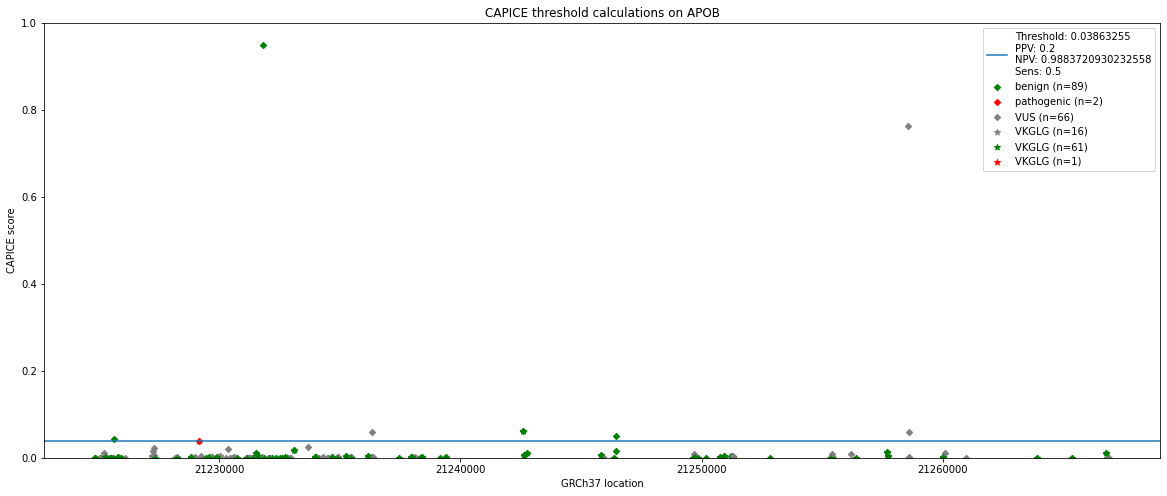

Still processing, currently on 203/11093


<Figure size 432x288 with 0 Axes>

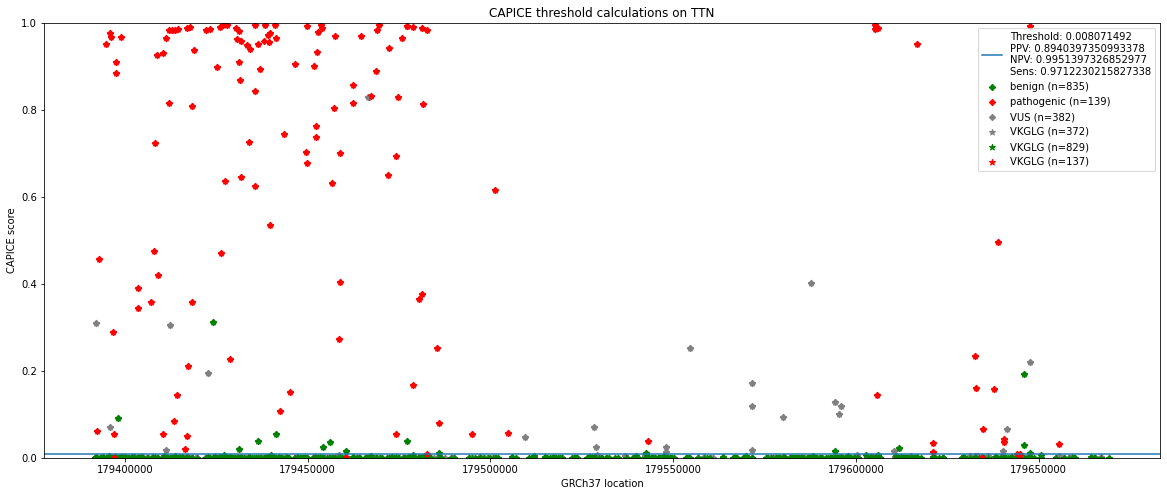

Still processing, currently on 238/10995


<Figure size 432x288 with 0 Axes>

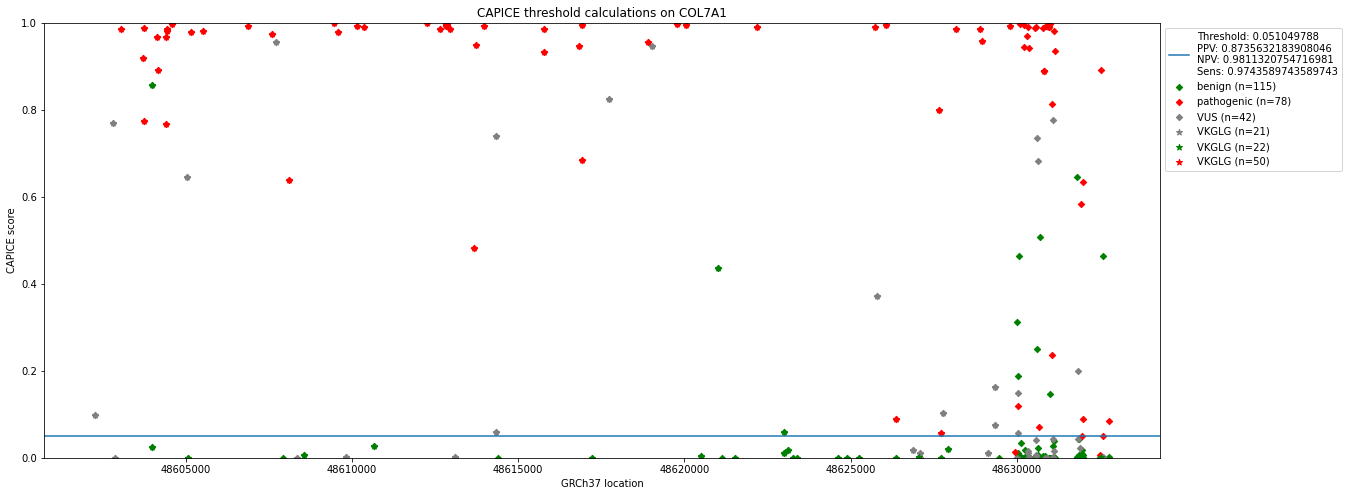

Still processing, currently on 292/10915
Still processing, currently on 333/10817


<Figure size 432x288 with 0 Axes>

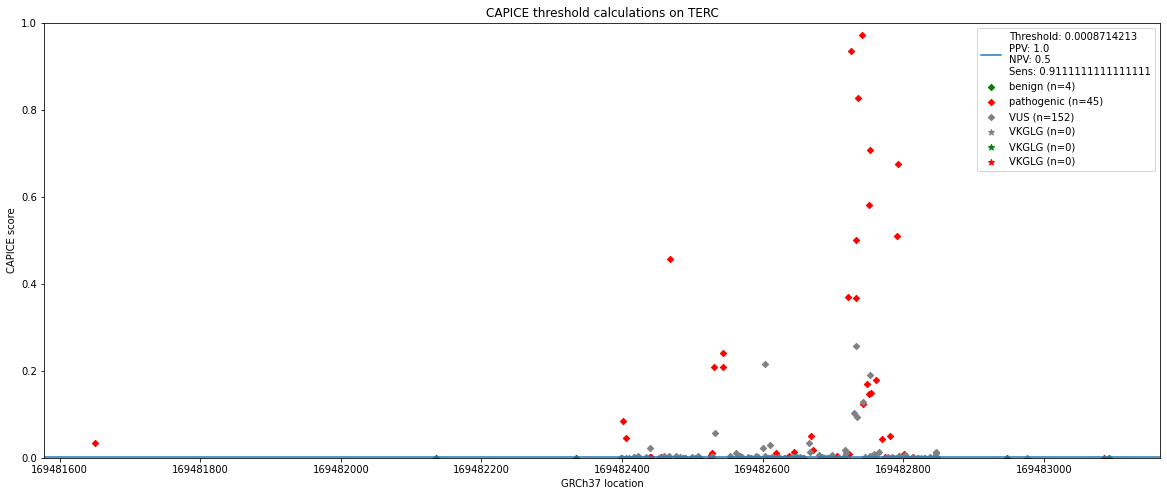

Still processing, currently on 385/10733
Still processing, currently on 426/10636
Still processing, currently on 471/10543
Still processing, currently on 513/10446
Still processing, currently on 571/10367
Still processing, currently on 617/10274
Still processing, currently on 673/10191
Still processing, currently on 724/10104
Still processing, currently on 765/10005
Still processing, currently on 815/9916


<Figure size 432x288 with 0 Axes>

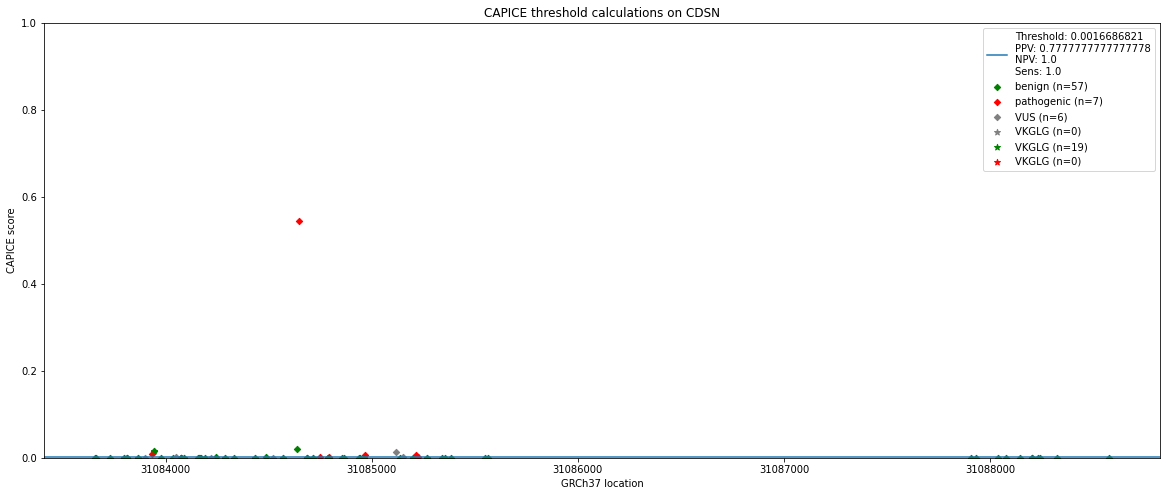

Still processing, currently on 847/9813
Still processing, currently on 889/9716
Still processing, currently on 944/9636
Still processing, currently on 990/9544
Still processing, currently on 1035/9450
Still processing, currently on 1083/9360
Still processing, currently on 1133/9271
Still processing, currently on 1180/9179
Still processing, currently on 1221/9080
Still processing, currently on 1266/8985
Still processing, currently on 1321/8901
Still processing, currently on 1371/8812
Still processing, currently on 1413/8715
Still processing, currently on 1460/8623
Still processing, currently on 1507/8532
Still processing, currently on 1552/8438
Still processing, currently on 1608/8356
Still processing, currently on 1655/8263
Still processing, currently on 1692/8162
Still processing, currently on 1741/8073
Still processing, currently on 1783/7975
Still processing, currently on 1832/7885
Still processing, currently on 1873/7786


<Figure size 432x288 with 0 Axes>

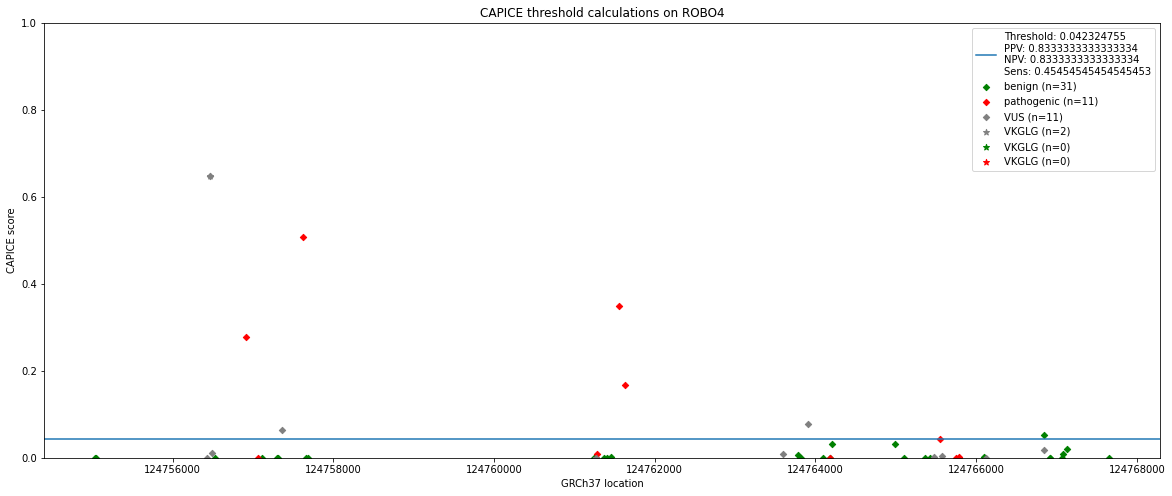

Still processing, currently on 1929/7709
Still processing, currently on 1969/7610
Still processing, currently on 2022/7524
Still processing, currently on 2069/7433
Still processing, currently on 2119/7344
Still processing, currently on 2163/7248


<Figure size 432x288 with 0 Axes>

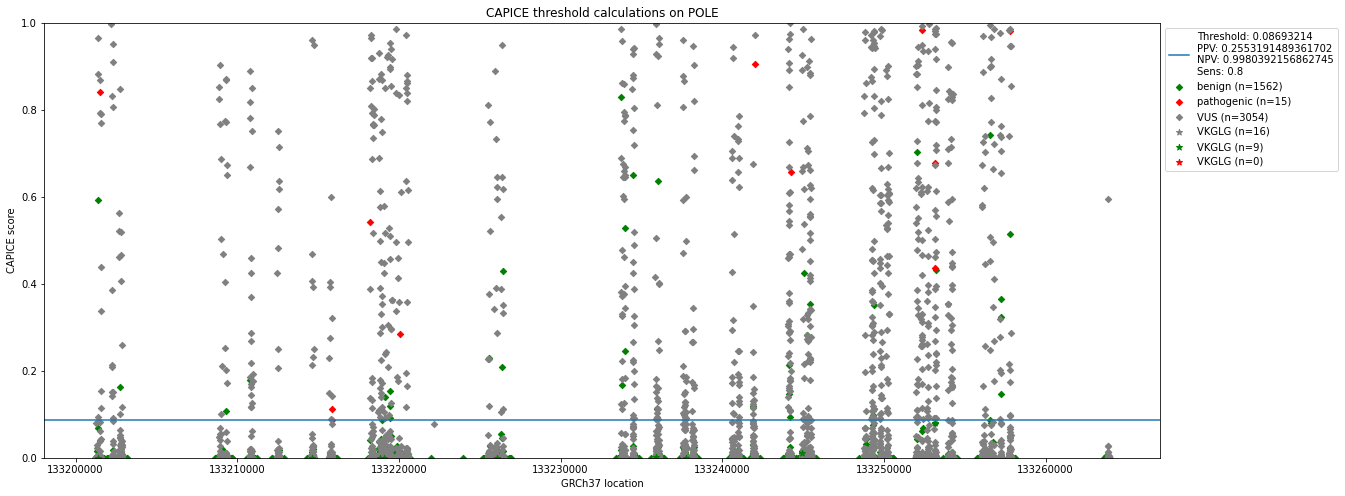

Still processing, currently on 2212/7164
Still processing, currently on 2260/7073
Still processing, currently on 2305/6978
Still processing, currently on 2362/6901
Still processing, currently on 2406/6804
Still processing, currently on 2467/6725
Still processing, currently on 2515/6632
Still processing, currently on 2562/6539


<Figure size 432x288 with 0 Axes>

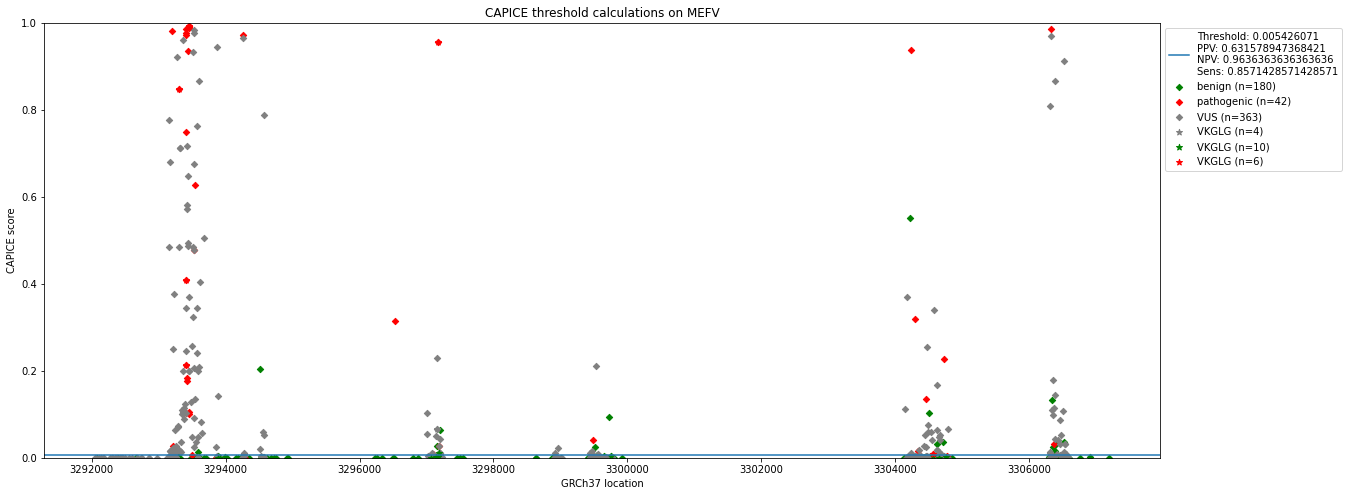

Still processing, currently on 2607/6449
Still processing, currently on 2658/6360
Still processing, currently on 2707/6269
Still processing, currently on 2754/6178
Still processing, currently on 2803/6088
Still processing, currently on 2839/5983


<Figure size 432x288 with 0 Axes>

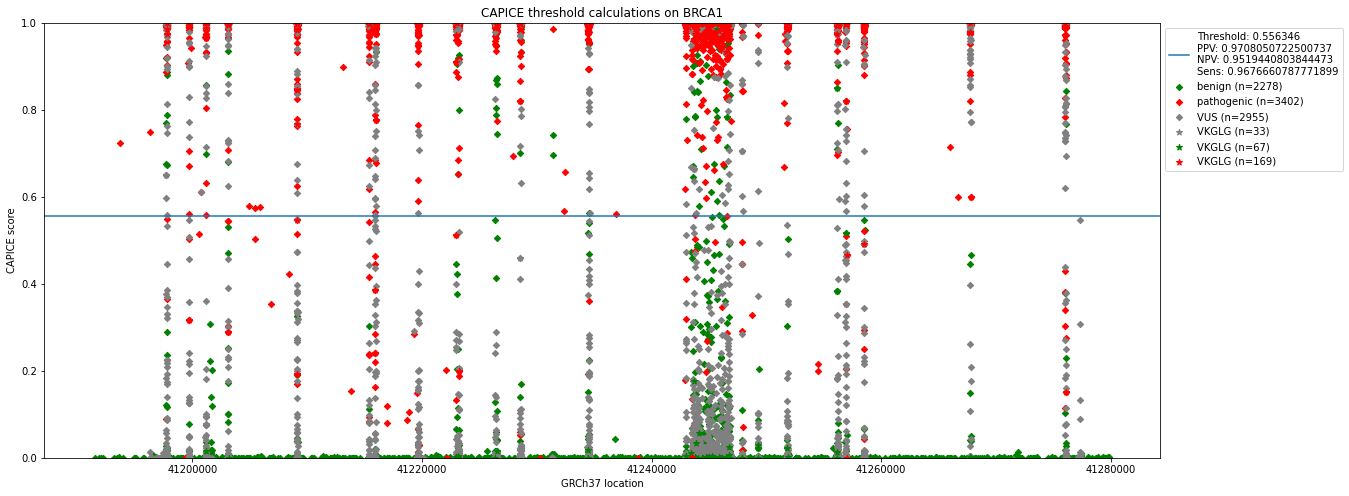

Still processing, currently on 2878/5890
Still processing, currently on 2926/5801
Still processing, currently on 2981/5716
Still processing, currently on 3035/5630
Still processing, currently on 3080/5534
Still processing, currently on 3114/5428
Still processing, currently on 3153/5326
Still processing, currently on 3183/5214
Still processing, currently on 3226/5117
Still processing, currently on 3264/5015
Still processing, currently on 3282/4892
Still processing, currently on 3333/4803


<Figure size 432x288 with 0 Axes>

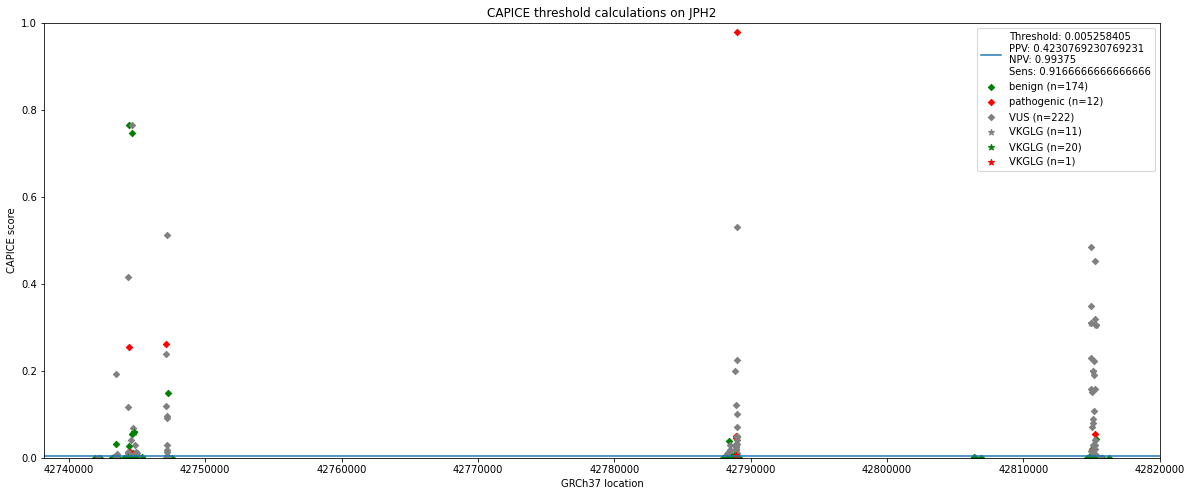

Still processing, currently on 3378/4713
Still processing, currently on 3431/4626
Still processing, currently on 3481/4536
Still processing, currently on 3523/4438
Still processing, currently on 3571/4347
Still processing, currently on 3627/4265
Still processing, currently on 3684/4183
Still processing, currently on 3722/4081
Still processing, currently on 3775/3994


<Figure size 432x288 with 0 Axes>

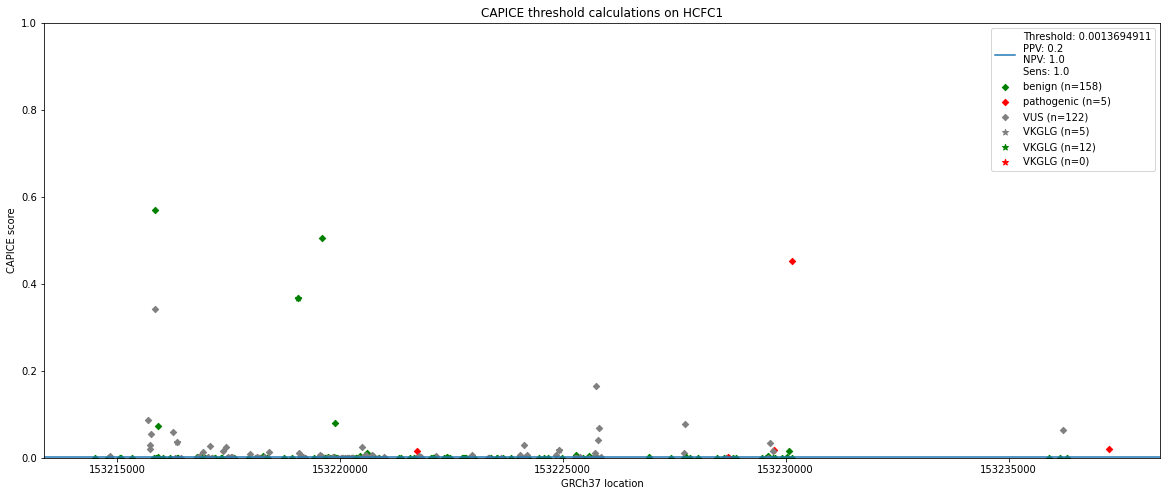

Still processing, currently on 3846/3933
Still processing, currently on 3884/3830
Still processing, currently on 3895/3698
Done. Total processed: 3914 (out of 11438 total)


<Figure size 432x288 with 0 Axes>

In [25]:
tracking_dataframe = pd.DataFrame(columns=['gene', 'n_benign', 'n_pathogenic', 'n_total', 'optimal_threshold', 'ppv', 'npv', 'sensitivity', 'discrepancies', 'false_positives'])

# PPV

total_genes = merge['GeneName'].unique().size
current = 1

reset_timer = time.time()

# Creating export location for all discrepancies
discrepancies_directory = '/home/rjsietsma/PycharmProjects/capice_updatr/ppv/discrepancies'
if not os.path.isdir(discrepancies_directory):
    os.makedirs(discrepancies_directory)



dot_size = 20
n_decimals = 4
minimal_variants = 1

track_changes = False

for gene in data['GeneName'].unique():
    # Timer
    curr_time = time.time()
    if curr_time - reset_timer > 10:
        print(f'Still processing, currently on {current}/{total_genes}')
        reset_timer = time.time()

    # Subset genes
    subset = data[data['GeneName'] == gene]

    # Check if benign samples are present
    benign_subset = subset[subset['binarized_label'] == 0]
    if benign_subset.shape[0] == 0:
        total_genes -= 1
        continue

    # Check if pathogenic samples are present
    patho_subset = subset[subset['binarized_label'] == 1]
    if patho_subset.shape[0] == 0:
        total_genes -= 1
        continue

    vus_subset = subset[subset['binarized_label'].isnull()]
    subset_nonan = subset[subset['binarized_label'].notnull()]
    # Checks passed, check if Gene is not already present in directory
    # if os.path.isfile(f'/home/rjsietsma/PycharmProjects/capice_updatr/per_gene_thresholds/{gene[0]}/{gene}.png') and track_changes:
    #     continue

    n_benign = subset_nonan[subset_nonan['binarized_label'] == 0].shape[0]
    n_pathogenic = subset_nonan[subset_nonan['binarized_label'] == 1].shape[0]
    n_total = n_benign + n_pathogenic

    if n_benign < minimal_variants or n_pathogenic < minimal_variants:
        ppv = np.NaN
        npv = np.NaN
        sensitivity = np.NaN
        optimal_threshold = np.NaN
        discrepancies = pd.DataFrame(columns=patho_subset.columns)
        n_discrepancies = np.NaN
        fp = np.NaN

    else:
        fpr, tpr, thresholds = roc_curve(
            y_score = subset_nonan['probabilities'], y_true = subset_nonan['binarized_label']
        )
        optimal_idx = np.argmax(tpr - fpr)
        optimal_threshold = thresholds[optimal_idx]
        n_patho_corr = patho_subset[patho_subset['probabilities'] >= optimal_threshold].shape[0]
        n_benign_wrong = benign_subset[benign_subset['probabilities'] >= optimal_threshold].shape[0]
        n_benign_corr = benign_subset[benign_subset['probabilities'] < optimal_threshold].shape[0]
        n_patho_wrong = patho_subset[patho_subset['probabilities'] < optimal_threshold].shape[0]
        try:
            ppv =  n_patho_corr / (n_patho_corr + n_benign_wrong)
        except ZeroDivisionError:
            ppv = np.nan
        try:
            npv = n_benign_corr / (n_benign_corr + n_patho_wrong)
        except ZeroDivisionError:
            npv = np.nan
        try:
            sensitivity = n_patho_corr / (n_patho_corr + n_patho_wrong)
        except ZeroDivisionError:
            sensitivity = np.nan
        # Only take discrepancies for vkgl samples, since we know those are high confidence
        # False negatives
        discrepancies = patho_subset[
            (patho_subset['probabilities'] < optimal_threshold) &
            (patho_subset['source'] == 'vkgl')
        ]
        fp = benign_subset[
            (benign_subset['probabilities'] >= optimal_threshold) &
            (benign_subset['source'] == 'vkgl')
        ].shape[0]
        n_discrepancies = discrepancies.shape[0]
        if n_discrepancies > 0:
            # export discrepancies
            if not os.path.isdir(f'{discrepancies_directory}/{gene}'):
                os.makedirs(f'{discrepancies_directory}/{gene}')
            exporting_discrepancies = discrepancies[['chr', 'pos', 'ref', 'alt', 'GeneName', 'FeatureID', 'class', 'probabilities']]
            exporting_discrepancies._is_copy = None
            exporting_discrepancies.rename(columns={'FeatureID': 'Transcript'}, inplace=True)
            exporting_discrepancies['predicted_class'] = 'B'
            exporting_discrepancies.loc[exporting_discrepancies[exporting_discrepancies['probabilities'] >= optimal_threshold].index, 'predicted_class'] = 'P'
            exporting_discrepancies.to_csv(f'{discrepancies_directory}/{gene}/{gene}.tsv.gz', sep='\t', index=False, compression='gzip')


    tracking_list = [
        gene,
        n_benign,
        n_pathogenic,
        n_total,
        optimal_threshold,
        ppv,
        npv,
        sensitivity,
        n_discrepancies,
        fp
    ]
    tracking_series = pd.Series(tracking_list, index=tracking_dataframe.columns)
    tracking_dataframe = tracking_dataframe.append(tracking_series, ignore_index=True)

    if gene in genes_of_interest:
        fig, axes = plt.subplots(1,1,figsize=(20,8))
        # Plotting the samples with the metrics
        axes.scatter(
            benign_subset['pos'],
            benign_subset['probabilities'],
            s=dot_size,
            marker='D',
            color='green',
            label=f'benign (n={n_benign})'
        )
        # plotting the samples with metrics
        axes.scatter(
            patho_subset['pos'],
            patho_subset['probabilities'],
            s=dot_size,
            marker='D',
            color='red',
            label=f'pathogenic (n={n_pathogenic})'
        )
        # plotting the VUS'es
        axes.scatter(
            vus_subset['pos'],
            vus_subset['probabilities'],
            s=dot_size,
            color='grey',
            marker='D',
            label=f'VUS (n={vus_subset.shape[0]})'
        )
        # plotting the Groningen VUS samples
        axes.scatter(
            vus_subset[vus_subset['source'] == 'vkgl']['pos'],
            vus_subset[vus_subset['source'] == 'vkgl']['probabilities'],
            s=dot_size * 2,
            marker='*',
            color='grey',
            label=f"VKGLG (n={vus_subset[vus_subset['source'] == 'vkgl'].shape[0]})"
        )
        # plotting the Groningen  benign samples
        axes.scatter(
            subset_nonan[(subset_nonan['source'] == 'vkgl') & (subset_nonan['binarized_label'] == 0)]['pos'],
            subset_nonan[(subset_nonan['source'] == 'vkgl') & (subset_nonan['binarized_label'] == 0)]['probabilities'],
            s=dot_size * 2,
            marker='*',
            color='green',
            label=f"VKGLG (n={subset_nonan[(subset_nonan['source'] == 'vkgl') & (subset_nonan['binarized_label'] == 0)].shape[0]})"
        )
        # plotting the Groningen pathogenic samples
        axes.scatter(
            subset_nonan[(subset_nonan['source'] == 'vkgl') & (subset_nonan['binarized_label'] == 1)]['pos'],
            subset_nonan[(subset_nonan['source'] == 'vkgl') & (subset_nonan['binarized_label'] == 1)]['probabilities'],
            s=dot_size * 2,
            marker='*',
            color='red',
            label=f"VKGLG (n={subset_nonan[(subset_nonan['source'] == 'vkgl') & (subset_nonan['binarized_label'] == 1)].shape[0]})"
        )

        axes.axhline(y=optimal_threshold, label=f'Threshold: {optimal_threshold}\nPPV: {ppv}\nNPV: {npv}\nSens: {sensitivity}')

        axes.set_ylim(0,1)
        axes.ticklabel_format(useOffset=False, style='plain')
        handles, labels = axes.get_legend_handles_labels()
        # red_patch = mpatches.Patch(color='red', label=f'P area ({round(pathogenic_threshold, n_decimals)}-1)')
        # handles.append(red_patch)
        # green_patch = mpatches.Patch(color='green', label=f'B area (0-{round(benign_threshold, n_decimals)})')
        # handles.append(green_patch)
        axes.legend(bbox_to_anchor=(1.0,1.0), handles=handles)
        axes.set_ylabel('CAPICE score')
        axes.set_xlabel('GRCh37 location')
        axes.set_title(f'CAPICE threshold calculations on {gene}')
        # export_loc = f'/home/rjsietsma/PycharmProjects/capice_updatr/per_gene_thresholds/{gene[0]}'
        export_loc = f'/home/rjsietsma/PycharmProjects/capice_updatr/POC_thresholds/'
        # export_loc = f'/home/rjsietsma/PycharmProjects/capice_updatr/POC_thresholds/{ci}'
        if not os.path.exists(export_loc):
            os.makedirs(export_loc)
        plt.savefig(f'{export_loc}/{gene}.png')
        plt.show()
        plt.figure().clear()
        plt.close('all')
        plt.cla()
        plt.clf()
        gc.collect()
        current_confidence = 100

    current += 1

print(f"Done. Total processed: {current} (out of {merge['GeneName'].unique().size} total)")

In [26]:
tracking_dataframe

,gene,n_benign,n_pathogenic,n_total,optimal_threshold,ppv,npv,sensitivity,discrepancies,false_positives
0,SKI,2,1,3,0.982573,1.000000,1.000000,1.000000,0,0
1,CAMTA1,10,2,12,0.773537,1.000000,1.000000,1.000000,0,0
2,MTHFR,8,4,12,0.316441,1.000000,1.000000,1.000000,0,0
3,HSPG2,24,1,25,0.973380,1.000000,1.000000,1.000000,0,0
4,LDLRAP1,3,1,4,0.097298,1.000000,1.000000,1.000000,0,0
...,...,...,...,...,...,...,...,...,...,...
3909,XPC,1,2,3,0.931200,1.000000,1.000000,1.000000,0,0
3910,GLB1,6,3,9,0.625156,1.000000,1.000000,1.000000,0,0
3911,CRTAP,4,2,6,0.076285,1.000000,1.000000,1.000000,0,0
3912,SCN5A,60,14,74,0.051344,0.722222,0.982143,0.928571,1,5


In [28]:
tracking_dataframe.to_csv('../datafiles/Thresholds/ppv_tracking_dataframe_v2.csv.gz', index=False, compression='gzip')
# tracking_dataframe = pd.read_csv('../datafiles/Thresholds/ppv_tracking_dataframe.csv.gz')

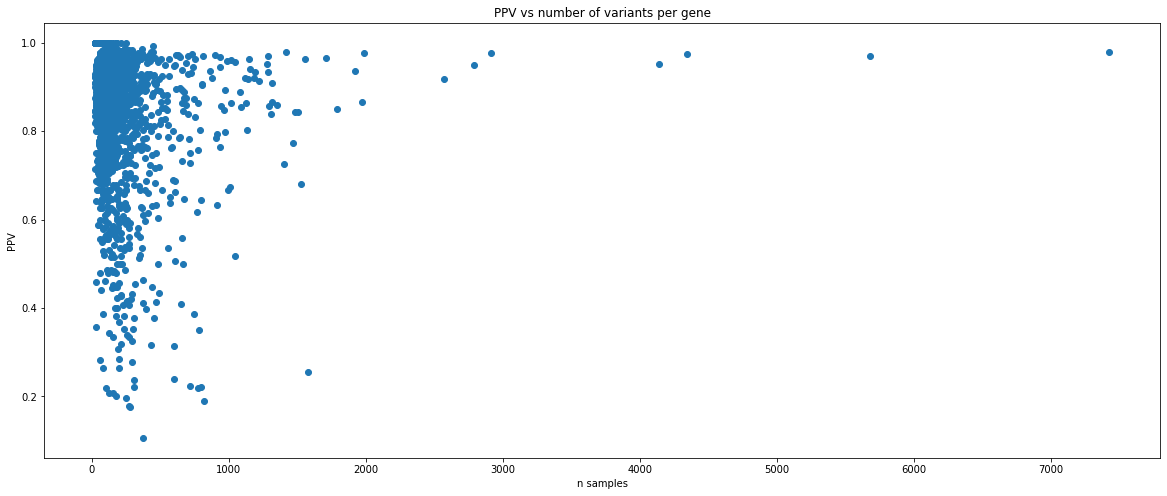

In [13]:
tracking_nonan = tracking_dataframe[tracking_dataframe['ppv'].notnull()]
fig, axes = plt.subplots(1,1,figsize=(20,8))
axes.scatter(tracking_nonan['n_total'], tracking_nonan['ppv'])
axes.set_title('PPV vs number of variants per gene')
axes.set_xlabel('n samples')
axes.set_ylabel('PPV')
plt.show()

/home/rjsietsma/PycharmProjects/capice_updatr/venv/lib/python3.9/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


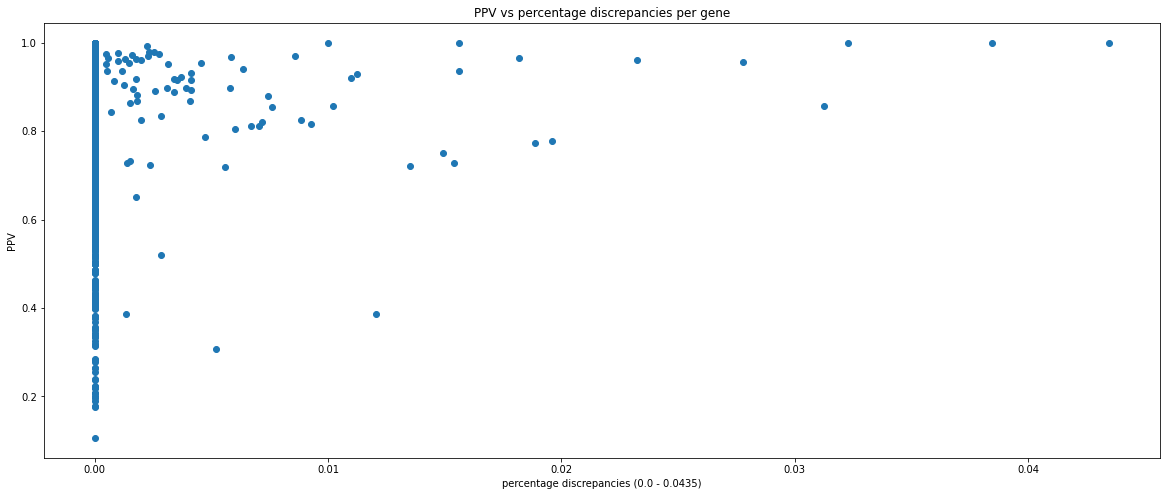

In [14]:
tracking_nonan['p_discrepancies'] = tracking_nonan['discrepancies'] / tracking_nonan['n_total']
fig, axes = plt.subplots(1,1,figsize=(20,8))
axes.scatter(tracking_nonan['p_discrepancies'], tracking_nonan['ppv'])
axes.set_title('PPV vs percentage discrepancies per gene')
axes.set_xlabel(f'percentage discrepancies ({tracking_nonan["p_discrepancies"].min()} - {round(tracking_nonan["p_discrepancies"].max(), 4)})')
axes.set_ylabel('PPV')
plt.show()

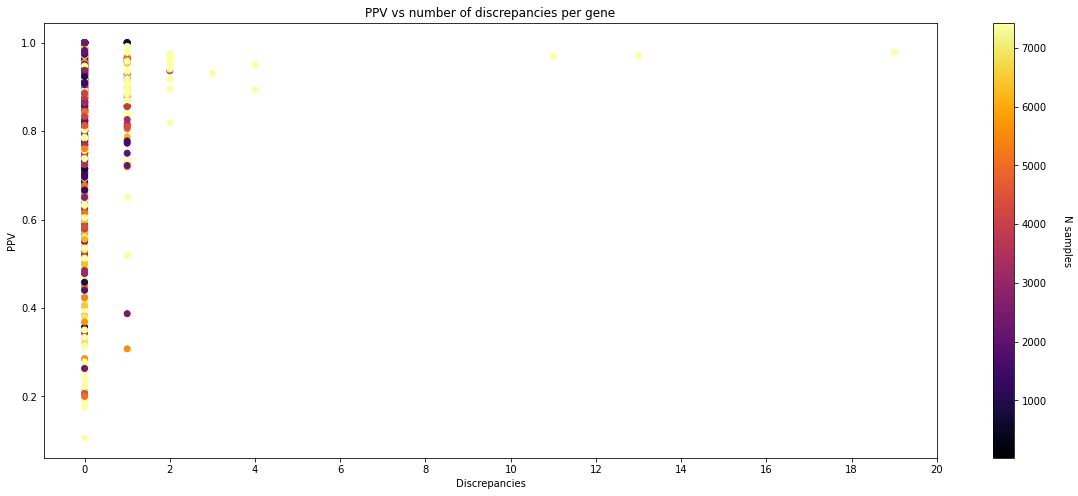

In [15]:
colormap = 'inferno'

my_cmap = plt.cm.get_cmap(colormap)
colors = my_cmap(tracking_nonan['n_total'].astype(int))

fig, axes = plt.subplots(1,1,figsize=(20,8))
axes.scatter(tracking_nonan['discrepancies'], tracking_nonan['ppv'], c=colors)
axes.set_title('PPV vs number of discrepancies per gene')
axes.set_xlabel('Discrepancies')
axes.set_ylabel('PPV')
axes.set_xticks(np.arange(0,22, 2))

sm = ScalarMappable(cmap=colormap, norm=plt.Normalize(tracking_nonan['n_total'].min(), tracking_nonan['n_total'].max()))
sm.set_array([])
cbar = plt.colorbar(sm, ax=axes)
cbar.set_label('N samples', rotation=270, labelpad=25)

plt.show()

In [16]:
tracking_nonan[tracking_nonan['discrepancies'] <= 5]['discrepancies'].sum()

96.0

In [35]:
tracking_nonan[tracking_nonan['sensitivity'] <= 0.7].sort_values(by='sensitivity', ascending=True)[:20]

,gene,n_benign,n_pathogenic,n_total,optimal_threshold,ppv,npv,sensitivity,discrepancies,false_positives,p_discrepancies
3815,MT-TL1,10,15,25,0.000269,0.714286,0.444444,0.333333,0.0,0.0,0.000000
3554,MT-CYB,135,46,181,0.001275,0.447368,0.797203,0.369565,0.0,0.0,0.000000
3825,MT-ATP6,161,35,196,0.003090,0.368421,0.867089,0.400000,0.0,0.0,0.000000
1914,ROBO4,31,11,42,0.042325,0.833333,0.833333,0.454545,0.0,0.0,0.000000
898,KCNQ5,22,15,37,0.019158,1.000000,0.814815,0.666667,0.0,0.0,0.000000
3827,MT-CO1,89,31,120,0.001622,0.724138,0.890110,0.677419,0.0,0.0,0.000000
539,ANK2,584,16,600,0.014943,0.314286,0.991150,0.687500,0.0,0.0,0.000000
392,TTC14,23,10,33,0.012028,1.000000,0.884615,0.700000,0.0,0.0,0.000000
2995,TGIF1,54,10,64,0.065102,1.000000,0.947368,0.700000,1.0,0.0,0.015625


In [ ]:
out_thresholds = pd.read_csv('../datafiles/Backups/gene_tracking_half.csv.gz')
out_thresholds


In [ ]:
out_thresholds.sort_values(by='vkgl_b_wro', ascending=False)[:20]

In [ ]:
out_thresholds.sort_values(by='vkgl_p_wro', ascending=False)[:10]

In [ ]:
out_thresholds.sort_values(by='vkgl_b_corr', ascending=False)[:10]

In [ ]:
out_thresholds.sort_values(by='vkgl_p_corr', ascending=False)[:10]

In [ ]:
out_thresholds[out_thresholds['high_confidence'] == 1]

In [ ]:
out_thresholds[['vkgl_b_corr', 'vkgl_b_vus', 'vkgl_b_wro', 'vkgl_p_corr', 'vkgl_p_vus', 'vkgl_p_wro']].sum().sum()

In [ ]:
out_thresholds[['vkgl_b_corr', 'vkgl_p_corr']].sum().sum()

In [ ]:
out_thresholds[['vkgl_b_wro', 'vkgl_p_wro']].sum()

In [ ]:
out_thresholds[['vkgl_b_wro', 'vkgl_p_wro']].std()

In [ ]:
out_thresholds[out_thresholds['pathogenic_threshold'] < 0]

In [ ]:
#TODO: Check if threshold determining code is correct (see JPH2)

#TODO: Investigate final_confidence in terms of trustworthyness of gene

#TODO: make list of 535 incorrect variants and make list available on G drive for GD

#TODO: make scatter plot, each point is gene, on x-axis the benign threshold and y-axis the pathogenic threshold

#TODO: make statistics on percent correct vs percent vus and wrong

benign = 'benign_threshold'
pathogenic = 'pathogenic_threshold'

fig, axe = plt.subplots(1,1,figsize=(20,8))

axe.hist(out_thresholds[benign], bins=100, alpha=0.4, color='green', label='Benign')
axe.hist(out_thresholds[pathogenic], bins=100, alpha=0.4, color='red', label='Pathogenic')
axe.hist(out_thresholds['final_confidence'] / 100, bins=100, alpha=0.6, color='black', label='Confidence')  #/100, for formatting
axe.legend()
plt.show()

In [ ]:
# Threshold

total_genes = merge['GeneName'].unique().size
current = 0
current_confidence = 100
reset_timer = time.time()
    
dot_size = 10
n_decimals = 4

ci = 0.95
track_changes = False

for gene in merge['GeneName'].unique():
    # Timer
    current += 1
    curr_time = time.time()
    if curr_time - reset_timer > 10:
        print(f'Still processing, currently on {current}/{total_genes}')
        reset_timer = time.time()

    has_threshold = False
        
    # Subset genes
    subset = merge[merge['GeneName'] == gene]
    
    # Check if benign samples are present
    benign_subset = subset[subset['binarized_label'] == 0]
    if benign_subset.shape[0] == 0:
        total_genes -= 1
        current -= 1
        current_confidence = 100
        continue
        
    # Check if pathogenic samples are present
    patho_subset = subset[subset['binarized_label'] == 1]
    if patho_subset.shape[0] == 0:
        total_genes -= 1
        current -= 1
        current_confidence = 100
        continue
    
    subset_gron = spec_gron[spec_gron['GeneName'] == gene]
        
    vus_subset = subset[subset['binarized_label'].isnull()]
    # Checks passed, check if Gene is not already present in directory
    # if os.path.isfile(f'/home/rjsietsma/PycharmProjects/capice_updatr/per_gene_thresholds/{gene[0]}/{gene}.png') and track_changes:
    #     continue
    
    benign_scores = benign_subset['probabilities']
    patho_scores = patho_subset['probabilities']
    
    pathogenic_lower_ci, _, _ = calc_ci(benign_scores, confidence=ci)
    _, _, benign_upper_ci = calc_ci(patho_scores, confidence=ci)
    if pathogenic_lower_ci < benign_upper_ci or math.isnan(pathogenic_lower_ci) or math.isnan(benign_upper_ci):
        # If enough samples are present, continue to calculate the sliding confidence threshold.
        for i in range(100):
            # Calculate 95 quantile benign area

            percentile_benign = np.percentile(benign_scores, current_confidence)

            # Calculate 5 quantile pathogenic area (since pathogenic runs from 1 to 0)

            percentile_patho = np.percentile(patho_scores, (100 - current_confidence))

            #TODO: PPV uitrekenen per gen, vanuit pathogeen gezien, met een slider van 100% naar 0% in stapjes van 5%

            if percentile_patho > percentile_benign:

                pathogenic_threshold = percentile_patho
                benign_threshold = percentile_benign
                high_confidence = 0
                has_threshold = True
                break
            else:
                current_confidence -= 1

    else:
        pathogenic_threshold = pathogenic_lower_ci
        benign_threshold = benign_upper_ci
        high_confidence = 1
        has_threshold = True

    if has_threshold:
        # Data processing
        # Metrics for benign
        n_benign_correct = benign_subset[benign_subset['probabilities'] <= benign_threshold].shape[0]
        n_benign_tot = benign_subset.shape[0]
        # Metrics for pathogenic
        n_patho_correct = patho_subset[patho_subset['probabilities'] >= pathogenic_threshold].shape[0]
        n_patho_tot = patho_subset.shape[0]
        # Calculating stats for benign
        vkgl_gron_benign_correct = subset_gron[(subset_gron['probabilities'] <= benign_threshold) & (subset_gron['binarized_label'] == 0)].shape[0]
        vkgl_gron_benign_wrong = subset_gron[(subset_gron['probabilities'] >= pathogenic_threshold) & (subset_gron['binarized_label'] == 0)].shape[0]
        vkgl_gron_benign_unclassed = subset_gron[(subset_gron['probabilities'] > benign_threshold) & (subset_gron['probabilities'] < pathogenic_threshold) & (subset_gron['binarized_label'] == 0)].shape[0]
        # Calculating stats for pathogenic
        vkgl_gron_patho_correct = subset_gron[(subset_gron['probabilities'] >= pathogenic_threshold) & (subset_gron['binarized_label'] == 1)].shape[0]
        vkgl_gron_patho_wrong = subset_gron[(subset_gron['probabilities'] <= benign_threshold) & (subset_gron['binarized_label'] == 1)].shape[0]
        vkgl_gron_patho_unclassed = subset_gron[(subset_gron['probabilities'] > benign_threshold) & (subset_gron['probabilities'] < pathogenic_threshold) & (subset_gron['binarized_label'] == 1)].shape[0]
        # Calculating stats for uncertain
        vkgl_gron_vus_benign = subset_gron[(subset_gron['probabilities'] <= benign_threshold) & (subset_gron['binarized_label'].isnull())].shape[0]
        vkgl_gron_vus_patho = subset_gron[(subset_gron['probabilities'] >= pathogenic_threshold) & (subset_gron['binarized_label'].isnull())].shape[0]
        vkgl_gron_vus_unclassed = subset_gron[(subset_gron['probabilities'] > benign_threshold) & (subset_gron['probabilities'] < pathogenic_threshold) & (subset_gron['binarized_label'].isnull())].shape[0]
        vkgl_gron_tot = subset_gron.shape[0]
        # Sub-subsetting the Groningen samples
        subset_gron_benign = subset_gron[subset_gron['binarized_label'] == 0]
        subset_gron_patho = subset_gron[subset_gron['binarized_label'] == 1]
        subset_gron_vus = subset_gron[subset_gron['binarized_label'].isnull()]
        save_to_thresholds = [
            pathogenic_threshold,
            n_patho_tot,
            n_patho_correct,
            benign_threshold,
            n_benign_tot,
            n_benign_correct,
            current_confidence,
            gene,
            vkgl_gron_benign_correct,
            vkgl_gron_benign_unclassed,
            vkgl_gron_benign_wrong,
            vkgl_gron_patho_correct,
            vkgl_gron_patho_unclassed,
            vkgl_gron_patho_wrong,
            vkgl_gron_vus_benign,
            vkgl_gron_vus_unclassed,
            vkgl_gron_vus_patho,
            high_confidence
        ]
        threshold_series = pd.Series(save_to_thresholds, index=thresholds.columns)
        if track_changes:
            thresholds.append(threshold_series, ignore_index=True).to_csv(thresholds_loc, mode='a', index=False, compression='gzip', header=False)
        if gene in genes_of_interest:
            fig, axes = plt.subplots(1,1,figsize=(20,8))
            # Plot benign area from 0 to upper CI
            axes.axhspan(
                0,
                benign_threshold,
                0,
                1,
                color='green',
                alpha=0.4
            )
            # Plotting the samples with the metrics
            axes.scatter(
                benign_subset['pos'],
                benign_subset['probabilities'],
                s=dot_size,
                marker='D',
                color='green',
                label=f'benign (n={n_benign_tot}) \n {n_benign_correct}/{n_benign_tot} ({round(n_benign_correct/n_benign_tot*100)}%)'
            )
            # Plot pathogenic area from lower CI to 1
            axes.axhspan(
                pathogenic_threshold,
                1,
                0,
                1,
                color='red',
                alpha=0.4
            )
            # plotting the samples with metrics
            axes.scatter(
                patho_subset['pos'],
                patho_subset['probabilities'],
                s=dot_size,
                marker='D',
                color='red',
                label=f'pathogenic (n={n_patho_tot}) \n {n_patho_correct}/{n_patho_tot} ({round(n_patho_correct/n_patho_tot*100)}%)'
            )
            # plotting the VUS'es
            axes.scatter(
                vus_subset['pos'],
                vus_subset['probabilities'],
                s=dot_size,
                color='grey',
                marker='D',
                label=f'VUS (n={vus_subset.shape[0]})'
            )
            # plotting the Groningen VUS samples
            axes.scatter(
                subset_gron_vus['pos'],
                subset_gron_vus['probabilities'],
                s=dot_size,
                marker='*',
                color='grey',
                label=f'VKGLG (n={subset_gron_vus.shape[0]})\n'
                f'VUS (B/U/P): {vkgl_gron_vus_benign}/{vkgl_gron_vus_unclassed}/{vkgl_gron_vus_patho}'
            )
            # plotting the Groningen  benign samples
            axes.scatter(
                subset_gron_benign['pos'],
                subset_gron_benign['probabilities'],
                s=dot_size,
                marker='*',
                color='green',
                label=f'VKGLG (n={subset_gron_benign.shape[0]})\n'
                f'B (C/U/W): {vkgl_gron_benign_correct}/{vkgl_gron_benign_unclassed}/{vkgl_gron_benign_wrong}'
            )
            # plotting the Groningen pathogenic samples
            axes.scatter(
                subset_gron_patho['pos'],
                subset_gron_patho['probabilities'],
                s=dot_size,
                marker='*',
                color='red',
                label=f'VKGLG (n={subset_gron_patho.shape[0]})\n'
                f'P (C/U/W): {vkgl_gron_patho_correct}/{vkgl_gron_patho_unclassed}/{vkgl_gron_patho_wrong}'
            )
            axes.ticklabel_format(useOffset=False, style='plain')
            handles, labels = axes.get_legend_handles_labels()
            red_patch = mpatches.Patch(color='red', label=f'P area ({round(pathogenic_threshold, n_decimals)}-1)')
            handles.append(red_patch)
            green_patch = mpatches.Patch(color='green', label=f'B area (0-{round(benign_threshold, n_decimals)})')
            handles.append(green_patch)
            axes.legend(bbox_to_anchor=(1.0,1.0), handles=handles)
            axes.set_ylabel('CAPICE score')
            axes.set_xlabel('GRCh37 location')
            additional_title = ''
            if high_confidence > 0:
                additional_title = f' HC'
            axes.set_title(f'CAPICE threshold calculations on {gene} (CONFIDENCE={current_confidence}%){additional_title}')
            # export_loc = f'/home/rjsietsma/PycharmProjects/capice_updatr/per_gene_thresholds/{gene[0]}'
            export_loc = f'/home/rjsietsma/PycharmProjects/capice_updatr/POC_thresholds/{gene}.png'
            # export_loc = f'/home/rjsietsma/PycharmProjects/capice_updatr/POC_thresholds/{ci}'
#             if not os.path.exists(export_loc):
#                 os.makedirs(export_loc)
            plt.savefig(f'{export_loc}')
            plt.show()
            plt.figure().clear()
            plt.close('all')
            plt.cla()
            plt.clf()
    gc.collect()
    current_confidence = 100

print(f"Done. Total processed: {current} (out of {merge['GeneName'].unique().size} total)")